In [44]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

In [2]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

nb_epoch = 50
batch_size = 32

averaging_kernel_weight_9x9 = 1./81
averaging_kernel_weight_5x5 = 1./25
averaging_kernel_weight_3x3 = 1./9

weights_dense = np.load("./weights/weights_dense_64.npy")

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ridiculously_small'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

train_descrs_dir      = base_dir + '/train'
validation_descrs_dir = base_dir + '/validation'
test_descrs_dir       = base_dir + '/test'

In [47]:
def loading_data(dir_patches, dir_descrs):
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = patch_in[5: 53, 5: 53]
        patch_out = block_reduce(patch_out, (8, 8), func=np.mean)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    
    print("in", patches_in.shape, "  out", patches_out.shape)
    
    return patches_in, patches_out

In [48]:
x_train, y_train = loading_data(train_data_dir, train_descrs_dir)
x_validation, y_validation = loading_data(validation_data_dir, validation_descrs_dir)

in (504, 56, 56)   out (504, 6, 6)
in (63, 56, 56)   out (63, 6, 6)


In [49]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

x_validation = x_validation.reshape((x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1))
y_validation = y_validation.reshape((y_validation.shape[0], y_validation.shape[1], y_validation.shape[2], 1))
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

(504, 56, 56, 1) (504, 6, 6, 1)
(63, 56, 56, 1) (63, 6, 6, 1)


In [7]:
def fixed_generator(x_train, y_train, batch_size):
    while True:
        batch_list_x = []
        batch_list_y = []
        
        for i in range(x_train.shape[0]):
            batch_list_x.append(x_train[i])
            batch_list_y.append(y_train[i])
            if len(batch_list_x) == batch_size:
                yield (np.array(batch_list_x),np.array(batch_list_y))
                batch_list_x = []
                batch_list_y = []

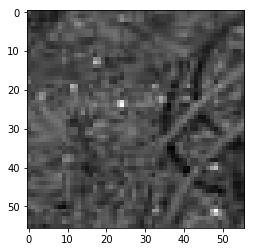

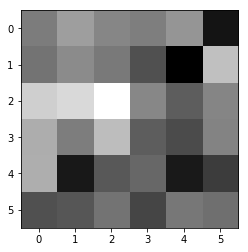

In [61]:
plt.imshow(x_train[3, :, :, 0], cmap='gray')
plt.show()
plt.imshow(y_train[3, :, :, 0], cmap='gray')
plt.show()

In [85]:
input_shape = (input_patch_size, input_patch_size, 1)
input_img = Input(shape=input_shape)

x = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])], trainable=False)(flattened)

# INSERT CODE HERE
x = Dense(1152, activation="relu")(briefed)
x = Reshape((6, 6, 32))(x)

x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)
decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

# x = UpSampling2D((2, 2))(x)



brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer=my_adadelta, loss="binary_crossentropy")
brief_ae.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_7 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               1180

In [80]:
from keras.callbacks import Callback
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print(K.eval(lr_with_decay))
        
lr_print = MyCallback()

In [84]:
my_adadelta = keras.optimizers.Adadelta(learning_rate=0.8, rho=0.95)

In [86]:
model_version = '0.0.0.2.2_decoder_dense1152_conv32_conv32_conv8_conv1__relu_last_sigmoid_bce_lr0.8'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

brief_ae.fit_generator(fixed_generator(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=200,
                validation_data=fixed_generator(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0],
                callbacks=[lr_print]
                )

brief_ae.save(base_dir + '/brief_ae_' + model_version + '.h5')


Epoch 1/200
124/504 [======>.......................] - ETA: 7s - loss: 0.6795

KeyboardInterrupt: 

predictions: 


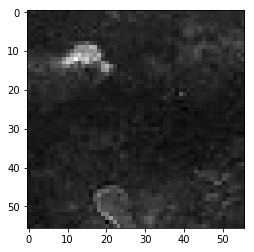

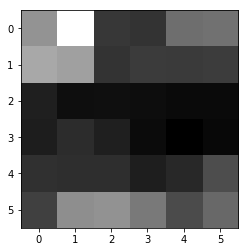

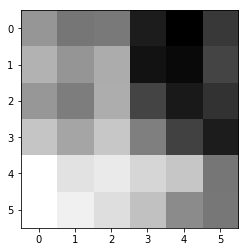

next


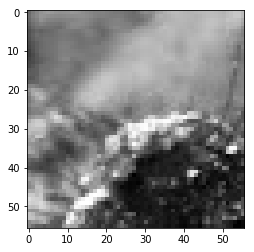

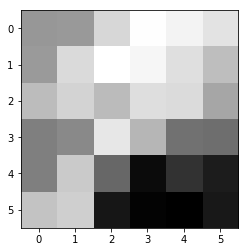

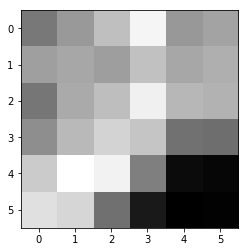

next


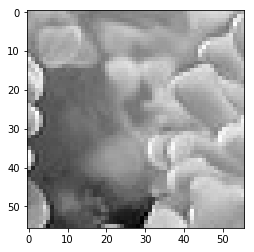

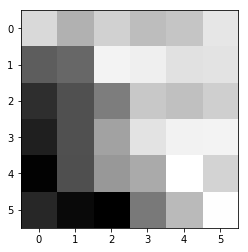

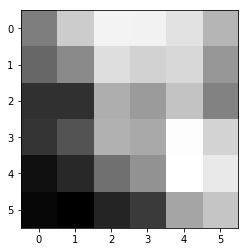

next


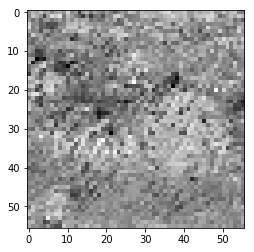

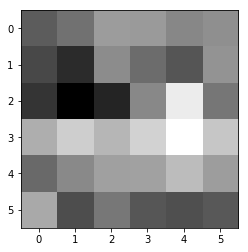

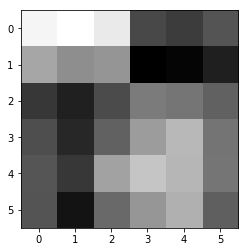

next


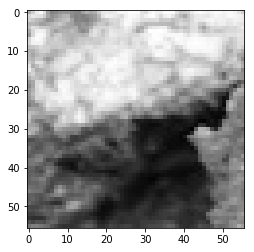

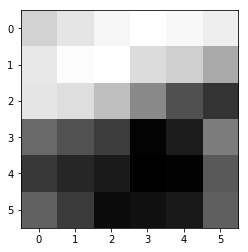

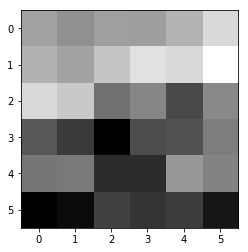

next


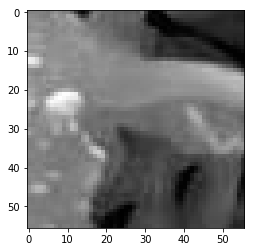

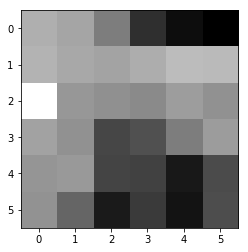

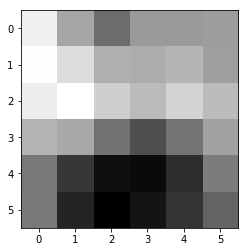

next


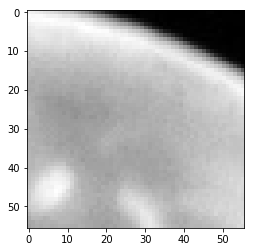

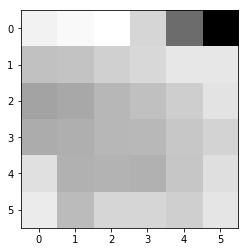

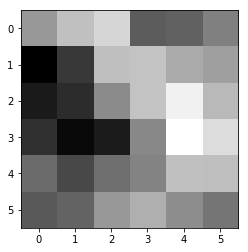

next


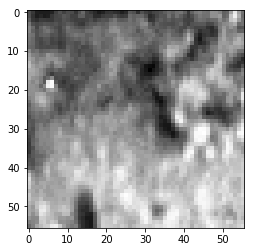

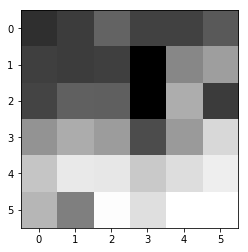

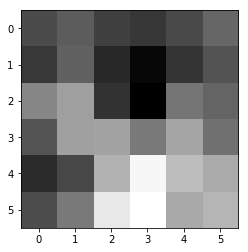

next


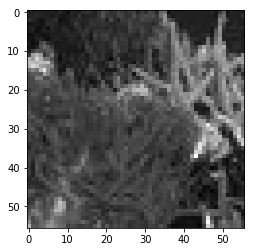

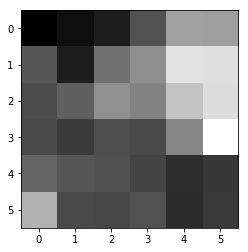

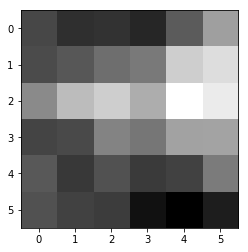

next


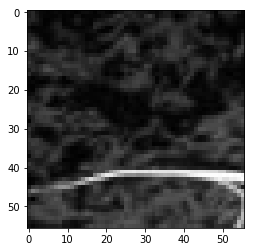

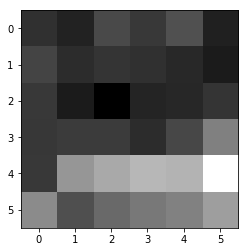

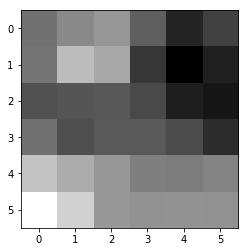

next


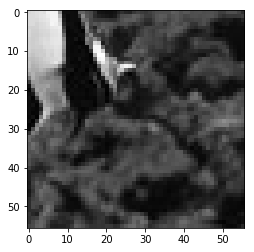

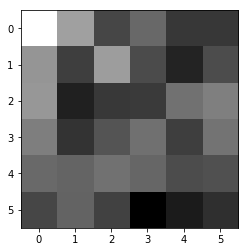

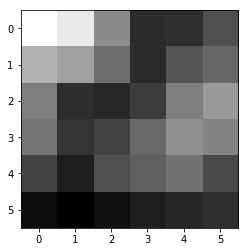

next


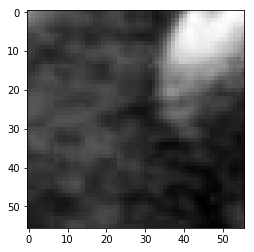

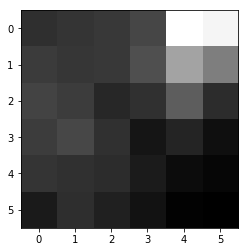

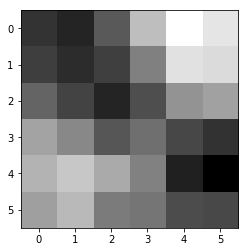

next


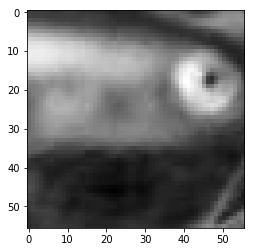

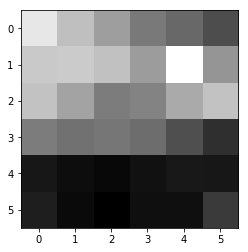

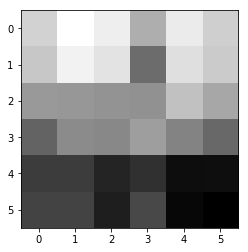

next


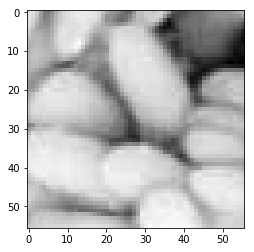

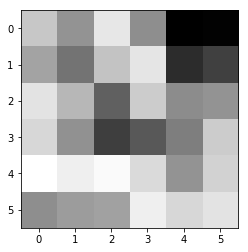

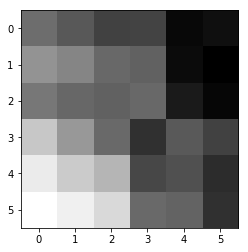

next


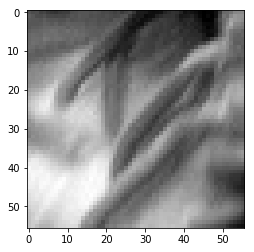

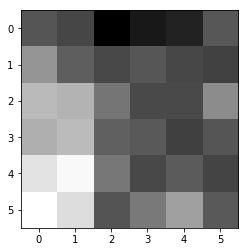

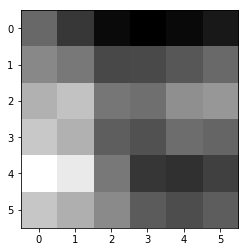

next


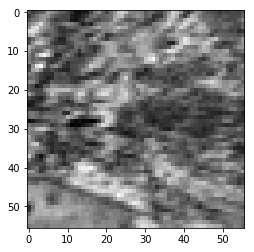

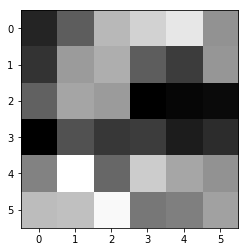

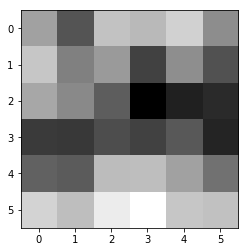

next


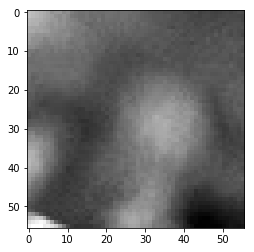

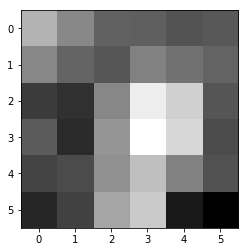

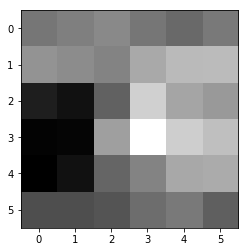

next


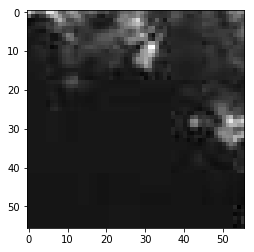

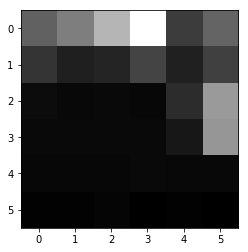

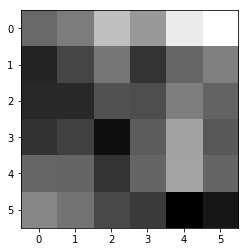

next


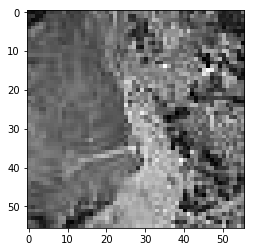

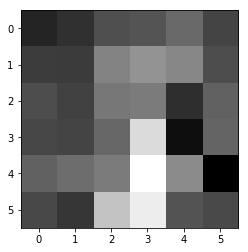

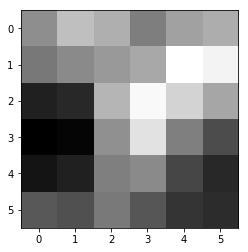

next


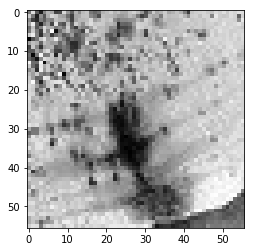

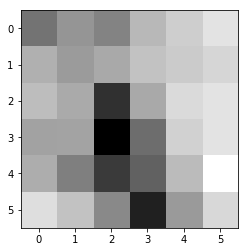

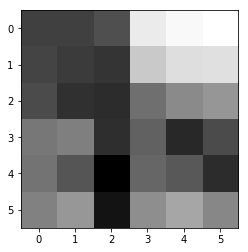

next


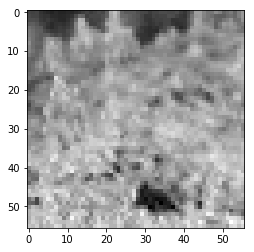

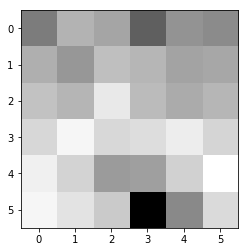

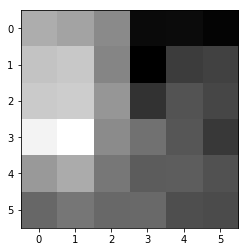

next


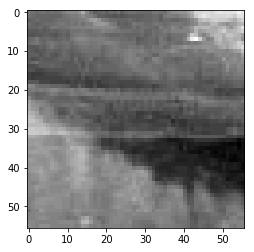

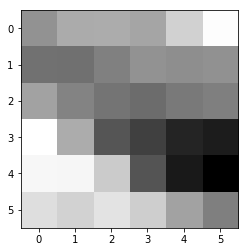

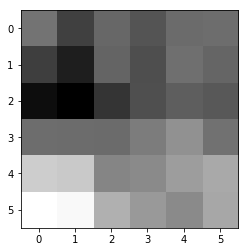

next


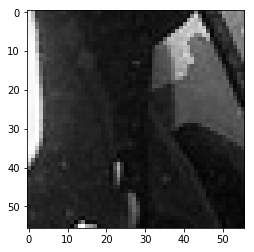

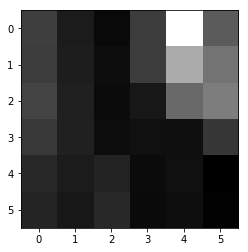

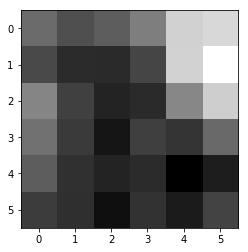

next


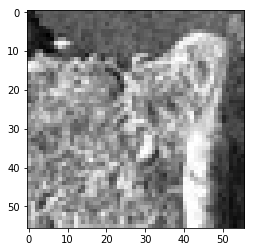

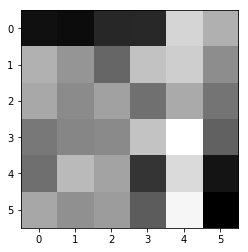

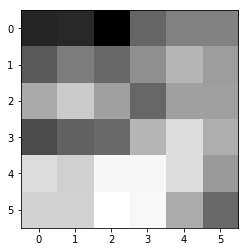

next


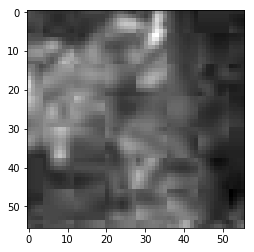

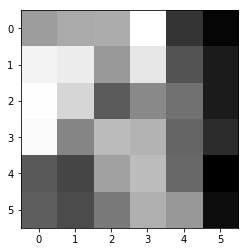

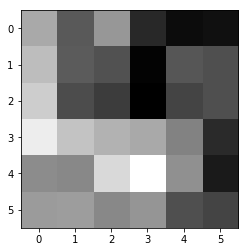

next


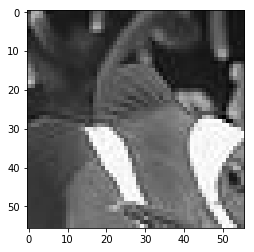

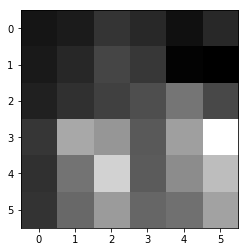

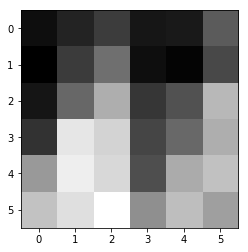

next


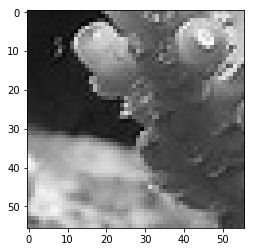

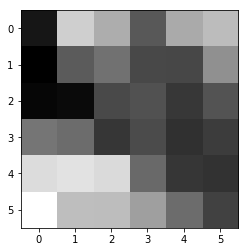

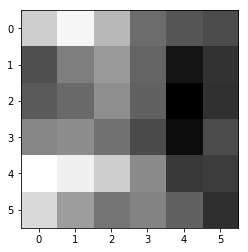

next


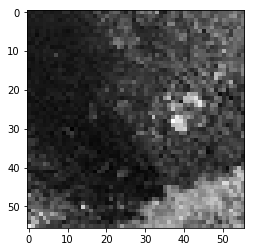

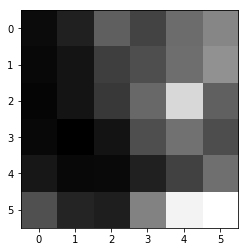

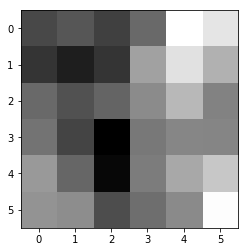

next


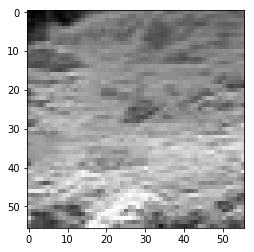

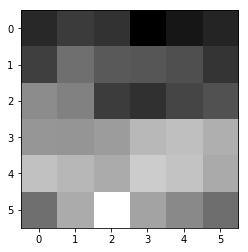

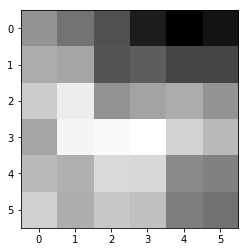

next


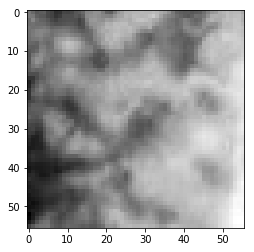

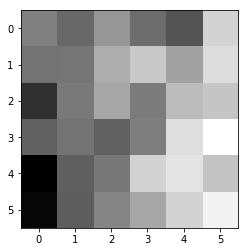

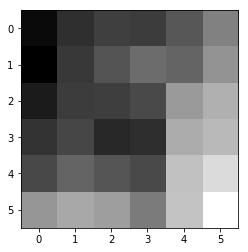

next


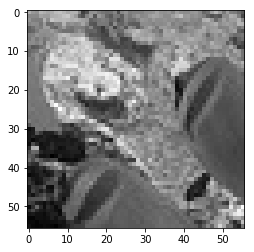

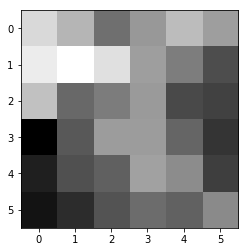

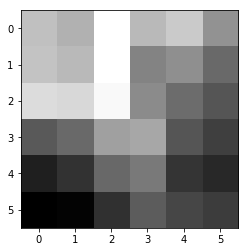

next


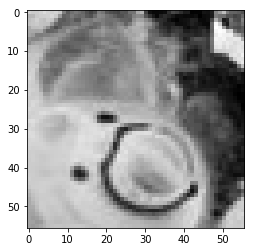

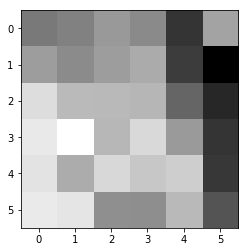

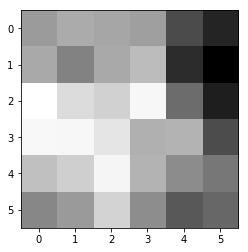

next


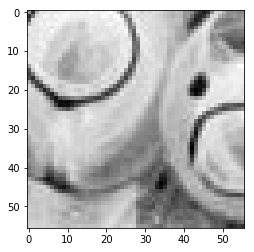

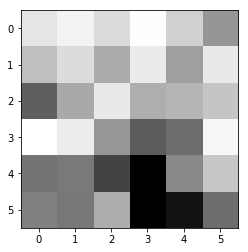

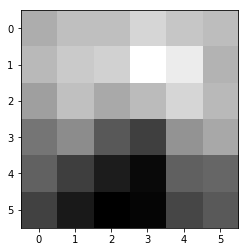

next


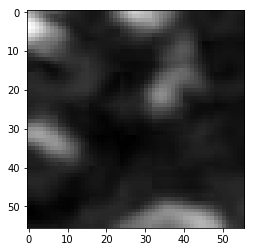

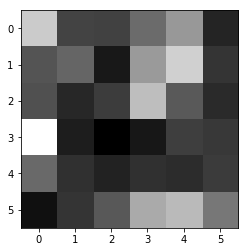

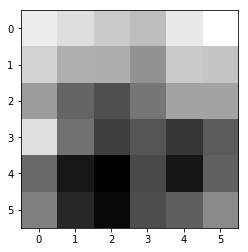

next


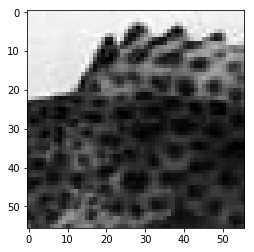

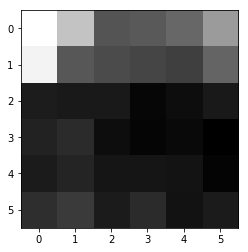

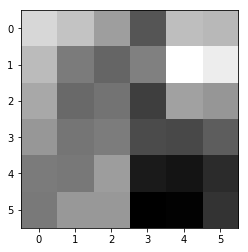

next


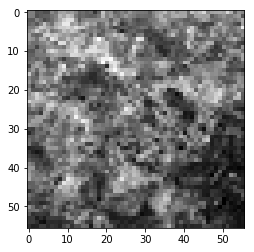

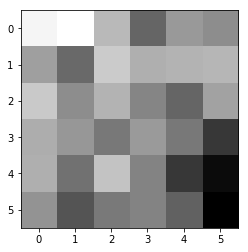

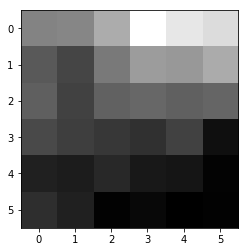

next


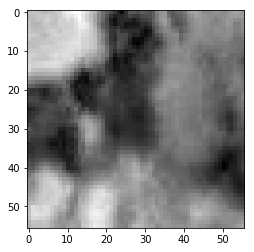

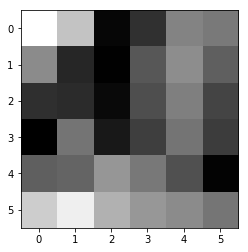

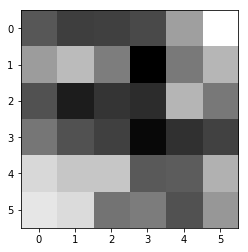

next


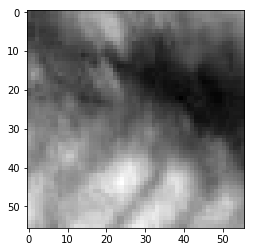

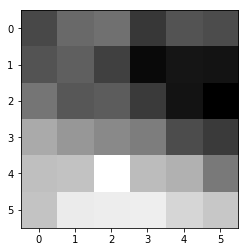

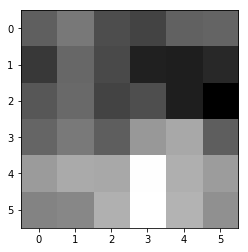

next


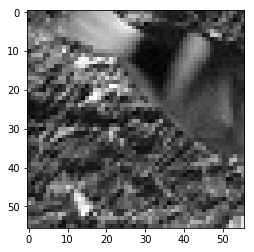

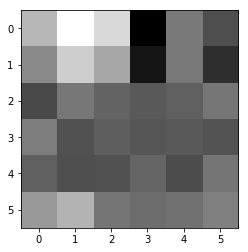

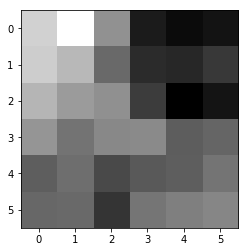

next


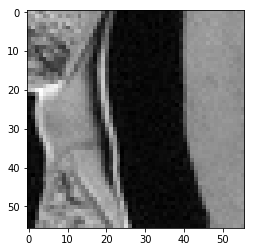

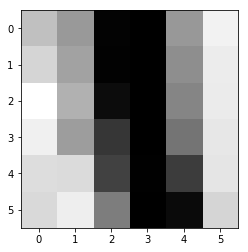

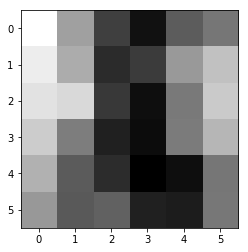

next


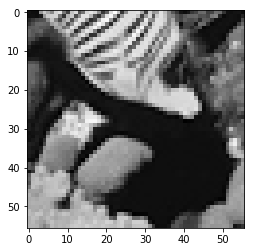

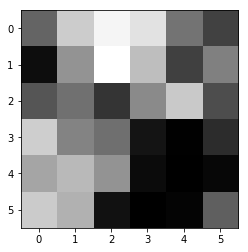

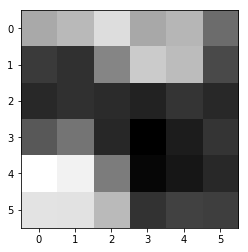

next


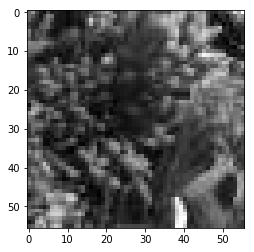

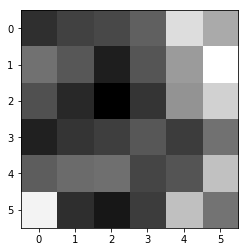

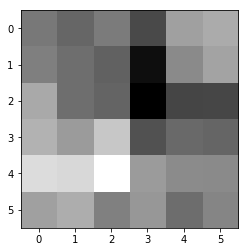

next


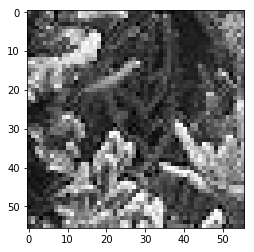

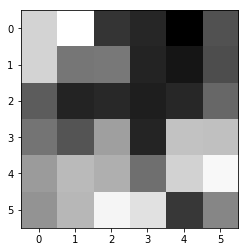

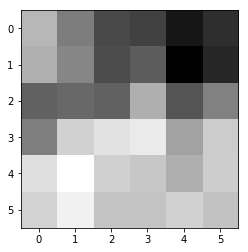

next


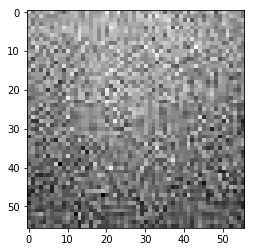

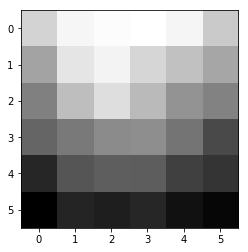

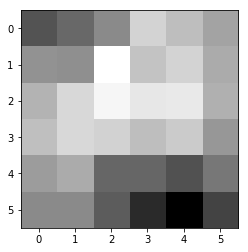

next


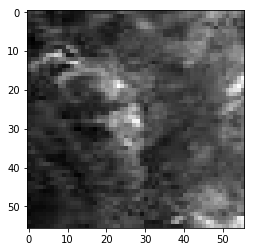

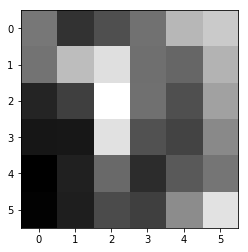

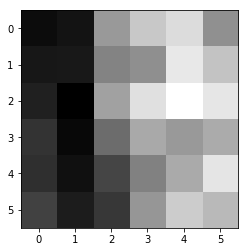

next


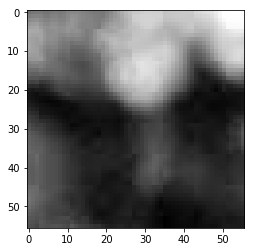

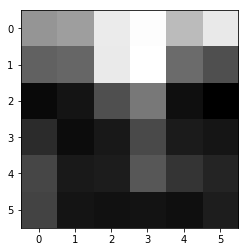

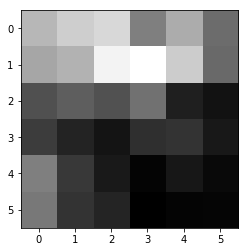

next


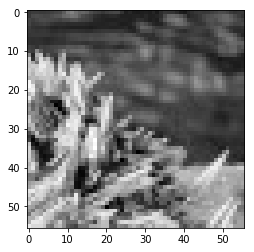

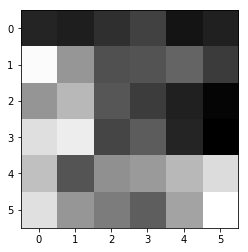

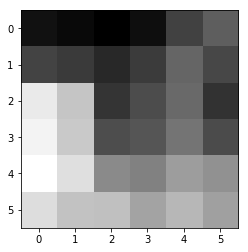

next


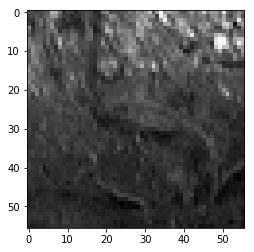

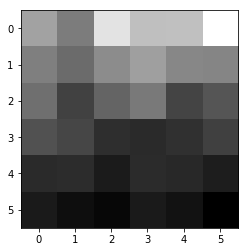

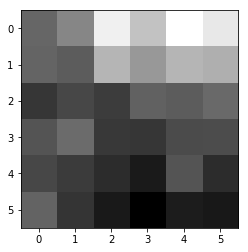

next


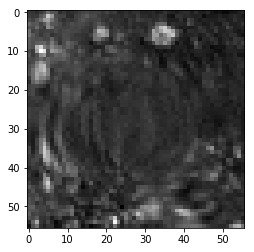

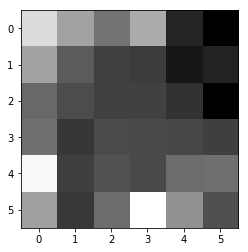

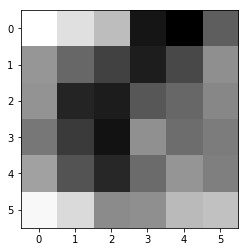

next


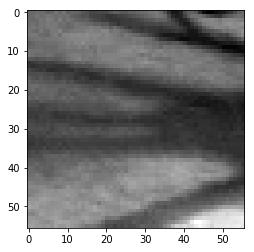

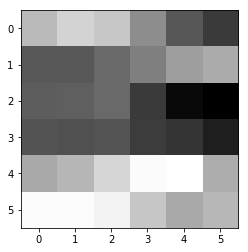

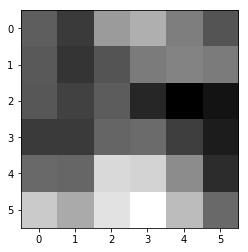

next


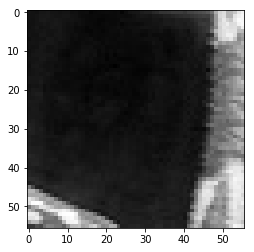

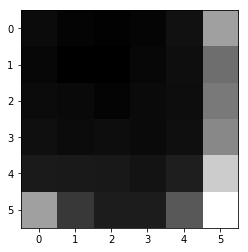

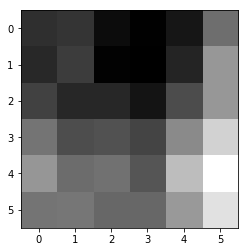

next


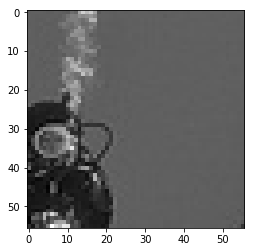

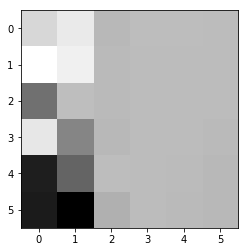

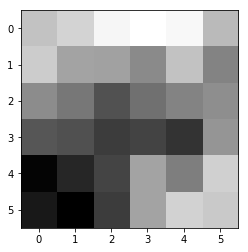

next


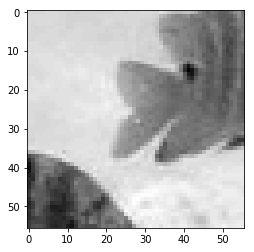

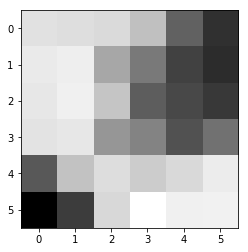

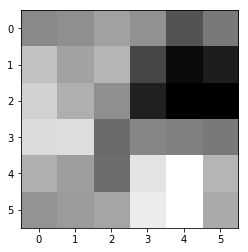

next


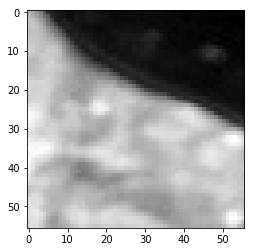

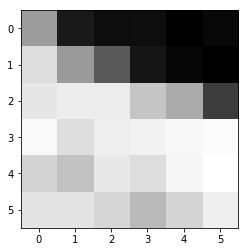

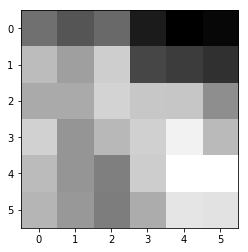

next


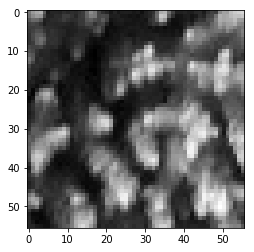

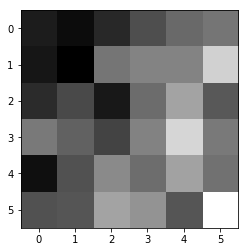

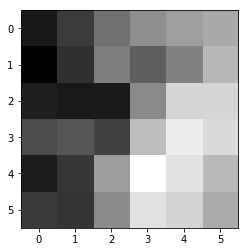

next


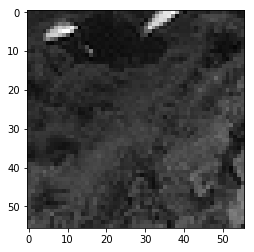

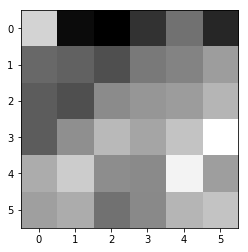

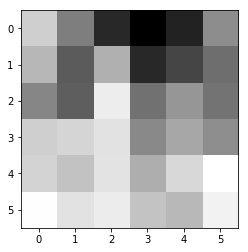

next


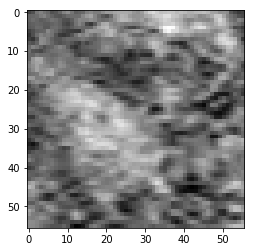

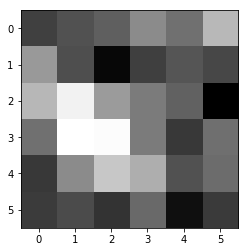

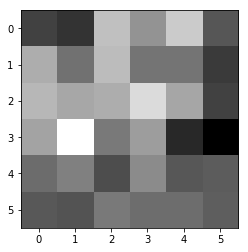

next


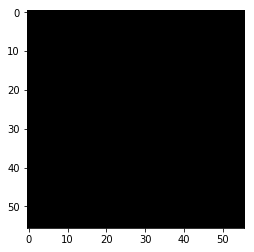

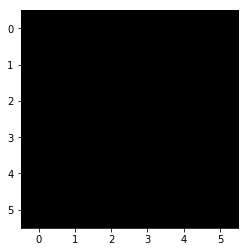

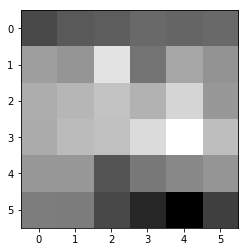

next


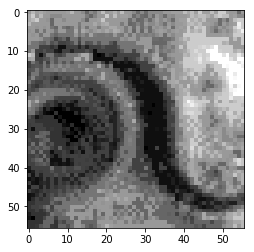

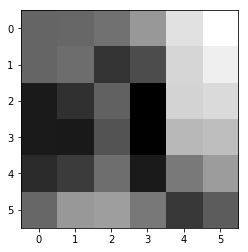

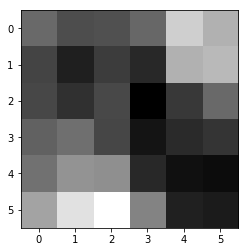

next


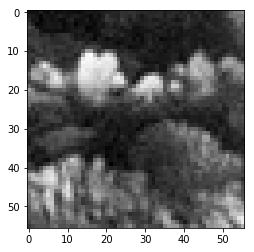

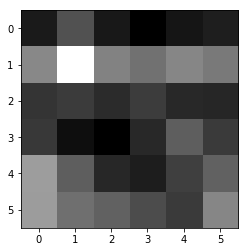

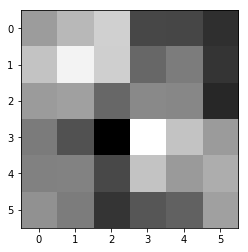

next


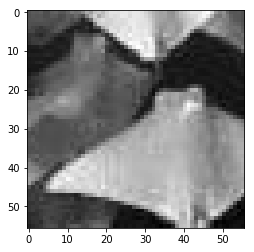

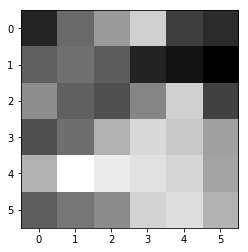

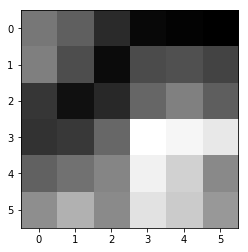

next


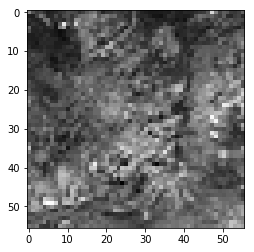

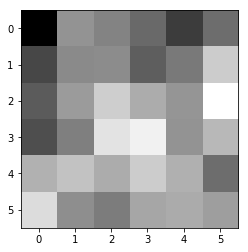

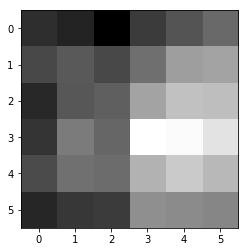

next


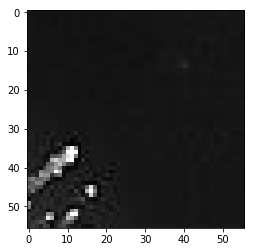

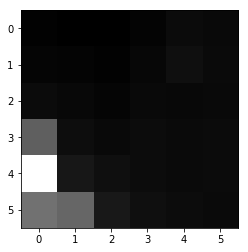

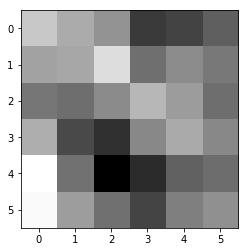

next


In [73]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        


images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
    ground_truth = im_1[5: 53, 5: 53, 0]
    ground_truth = block_reduce(ground_truth, (8, 8), func=np.mean)
    plt.imshow(ground_truth[:, :], cmap='gray')
    plt.show()
    
    
    pred_1 = predictions[i].reshape((6, 6))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    print("next")